# Домашнее задание к занятию 2.1: Деревья решений. Классификация

## Домашнее задание

**Lvl 1:**

* взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
* кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )
* определить самые важные фичи
* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

**Результат:** скрины нового сабмита на Kaggle и построенного дерева

**Lvl 2:** (опционально)

* С помощью функций sklearn.metrics.auc, precision, recall составить функцию для расчёта ROC-AUC, ROC-PRC
* Придумать себе интересную задачу на основе данных из интернета =) Спарсить ещё какой-нибудь сайт (не Ведомости) и решить задачу классификации. Делать свои проекты - круто. Если будут - кидайте мне =) [@NikitaKuznetsov](http://t.me/NikitaKuznesov)

Импорт билиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from scipy.stats.mstats import gmean

Считывание и предобработка данных. Подготовка к работе.

In [2]:
# Считывание данных
train = pd.read_csv('.\\titanic\\train.csv')
test = pd.read_csv('.\\titanic\\test.csv')
# Выделение столбца с целевыми значениями
y_train = train.Survived
train.drop('Survived', axis=1, inplace=True)
# Объединение данных train и test для облегчения дальнейшей обработки
train['is_test'] = 0
test['is_test'] = 1
df = pd.concat([train, test])
# Избавление от не информативных или тяжело интерпритируемых столбцов данных.
df["isMale"] = df.Sex.replace({"male": 1, "female":0})
df.drop(["Sex", "Cabin", "Ticket", "Name", "PassengerId"], axis=1, inplace=True)
# Избавление от котегорийных элементов. Трансформация их в матрицу с бинарными столбцами.
df_dummies = pd.get_dummies(df, columns=['Pclass', 'Embarked'])
X_train = df_dummies[df_dummies.is_test==0].drop('is_test', axis=1)
X_test = df_dummies[df_dummies.is_test==1].drop('is_test', axis=1)
# Заполнентие пустых значений/
columns = X_train.columns
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)
imputer.fit(X_train)
X_train_imputed = imputer.transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=columns)
# Нормировка
scaler = StandardScaler()
scaler.fit(X_train_imputed)
X_train_imputed_scaled = scaler.transform(X_train_imputed)
X_train_imputed_scaled = pd.DataFrame(X_train_imputed_scaled, columns=columns)
X_test_imputed_scaled = scaler.transform(imputer.transform(X_test))

Метод главных компонент. Определение оптимального количества компонент.

In [3]:
# Функция оценки качества построения дерева решений для разбиении на k главных компанент.
def calc_rezult(X,y,k):
    pca=decomposition.PCA(n_components=k)
    X2 = pca.fit_transform(X)
    model = LogisticRegression()
    model.fit( X2, y )
    y_pred = model.predict(X2)
    return [accuracy(y_train, y_pred), precision(y_train, y_pred), recall(y_train, y_pred)]

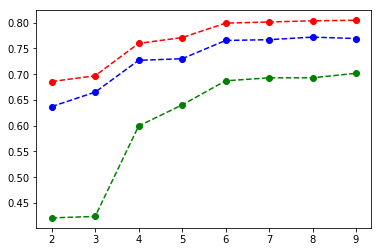

In [4]:
x_exp=np.arange(2,X_train_imputed_scaled.shape[1]-1);
y_exp=np.array([np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0])])
k=0;
for i in x_exp:
    y_exp[0][k] , y_exp[1][k] , y_exp[2][k] =calc_rezult(X_train_imputed_scaled,y_train,x_exp[k])
    k=k+1;
y_exp    
plt.plot(x_exp,y_exp[0],'ro--')
plt.plot(x_exp,y_exp[1],'bo--')
plt.plot(x_exp,y_exp[2],'go--')
plt.show()

Как можно видеть на графике оптимальное число главных компонент 6.

In [5]:
pca=decomposition.PCA(n_components=6)
X_train_new=pca.fit_transform(X_train_imputed_scaled)
X_test_new=pca.fit_transform(X_test_imputed_scaled)
# В качестве метрики сравнения в дальнейшем будем использовать среднегеометрическое от accuracy,precision и recall.
pca_metric=gmean(calc_rezult(X_train_new,y_train,6),axis=0)
y_train.shape

(891,)

Определение степени важности фичей.

In [6]:
# Функция оценки качества построения дерева решений.
def calc_rezult2(X,y):
    model = LogisticRegression()
    model.fit( X2, y )
    y_pred = model.predict(X2)
    return [accuracy(y_train, y_pred), precision(y_train, y_pred), recall(y_train, y_pred)]

[ 4  0  2  1  9  5  6  7  8 10  3]


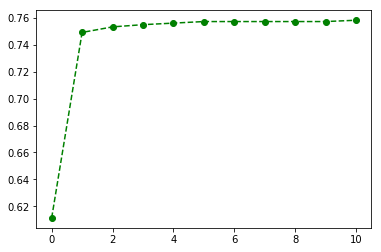

In [7]:
# Определение порядка значимостикомпонент

x_exp=np.arange(0,X_train_imputed_scaled.shape[1])
y_exp=np.array(np.zeros(x_exp.shape[0]))
k=0;
num_rep=1;
for i in x_exp:
    X2 = np.delete(X_train_imputed_scaled.values,(i), axis=1)
    y_exp[k] =gmean(calc_rezult2(X2,y_train),axis=0)
    k=k+1;
ix=(y_exp).argsort()
print(ix)
plt.plot(x_exp,y_exp[ix],'go--')

Теперь будем увеличивать количество фичей, начиная с самых значимых, до тех пор пока метрика качества не сравнится с результатом полученным по методуглавных компанент (k=6).

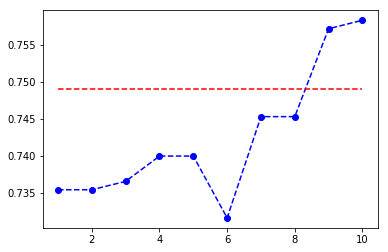

In [8]:
x_exp=np.arange(1,X_train_imputed_scaled.shape[1])
y_exp=np.array(np.zeros(x_exp.shape[0]))
k=0;
num_rep=1;
for i in x_exp:
    X2 = np.delete(X_train_imputed_scaled.values,(ix[:][i:]), axis=1)
    y_exp[k] =gmean(calc_rezult2(X2,y_train),axis=0)
    k=k+1;
plt.plot(x_exp,y_exp,'bo--')
plt.plot([x_exp[0],x_exp[-1]],[pca_metric,pca_metric],'r--')
plt.show()

Как можно видеть, качество сравнимое с тем, что получено по МГК, достигается лишь при участии 9 из исходных компанет.

In [9]:
# Функция оценки качества построения дерева решений c обучающей и тестовой выборками.
def calc_rezult3(X_train,y_train,X_test,y_test):
    model = LogisticRegression()
    model.fit( X_train, y_train )
    y_pred = model.predict(X_test)
    return [accuracy(y_test, y_pred), precision(y_test, y_pred), recall(y_test, y_pred)]

Распределение качества результатов выборо кросс валидации


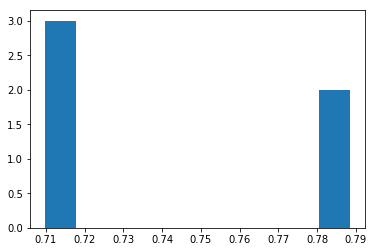

In [10]:
kfold=5
skf=StratifiedKFold(n_splits=kfold, shuffle=True, random_state=0)
buf=np.zeros(kfold)
k=0
for train_index, test_index in skf.split(X_train_new, y_train):
    X_trn, X_tst = X_train_new[train_index], X_train_new[test_index]
    y_trn, y_tst = y_train[train_index], y_train[test_index]
    buf[k]=gmean(calc_rezult3(X_trn,y_trn,X_tst,y_tst),axis=0)
    k=k+1
plt.hist(buf)
print("Распределение качества результатов выборо кросс валидации")

Как можно видеть при крос валидации с делениям на 5 частей (примерно по 180 точек в каждой) модель показывает деление по качеству на два значения (~0.71 и ~0.78). А среднее значение оказывается в районе 0.742.